In [9]:
#import libs
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [10]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test_tweets.csv")
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [32]:
print('\n\n\t\tTweets tagged as Non-Racist/Non-Sexist \n\n {}'.format(train.tweet[train.label == 0].head(10)))
print('\n\n\t\tTweets tagged as Racist/Sexist \n\n {}'.format(train.tweet[train.label == 1].head(10)))


counts = train.label.value_counts()
neg = counts[0]/train.shape[0]
pos = 1-neg
print('\n\nHateful/Racist: {},\nNon Hateful/Racist: {}'.format(pos*100,neg*100))



		Tweets tagged as Non-Racist/Non-Sexist 

 0     @user when a father is dysfunctional and is s...
1    @user @user thanks for #lyft credit i can't us...
2                                  bihday your majesty
3    #model   i love u take with u all the time in ...
4               factsguide: society now    #motivation
5    [2/2] huge fan fare and big talking before the...
6     @user camping tomorrow @user @user @user @use...
7    the next school year is the year for exams.ð...
8    we won!!! love the land!!! #allin #cavs #champ...
9     @user @user welcome here !  i'm   it's so #gr...
Name: tweet, dtype: object


		Tweets tagged as Racist/Sexist 

 13     @user #cnn calls #michigan middle school 'buil...
14     no comment!  in #australia   #opkillingbay #se...
17                                retweet if you agree! 
23       @user @user lumpy says i am a . prove it lumpy.
34     it's unbelievable that in the 21st century we'...
56               @user lets fight against  #love #peac

## Observations
The tweets have been anonymized and user handles have been replaced by <mark style="background-color: lightblue">@user</mark>. Also there is a class imbalance, where ~93% of the tweets are not hatefulr/racist. While there are multiple ways to deal with class imbalance, in this case we won't be doing that. Rather, we'll use F1 score as metric for evaluation of model.


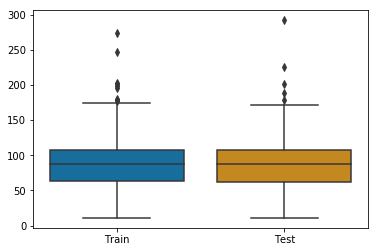

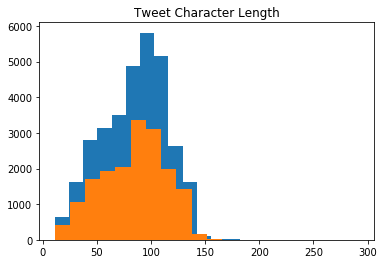

In [81]:
length_train = train.tweet.str.len()
length_test = test.tweet.str.len()
d = {'Train':length_train,'Test':length_test}
length_df = pd.DataFrame(d)
sns.boxplot(data = length_df,palette="colorblind")
# boxplt.show()
plt.figure()
plt.hist(length_train,bins=20,label="Train")
plt.hist(length_test,bins=20,label="Test")
plt.title('Tweet Character Length')
plt.show()



In [82]:
print('Train Data set shape : {} \nTest Data set shape : {}'.format(train.shape,test.shape))
labels = train.label
combined = train.append(test,ignore_index=True)

Train Data set shape : (31962, 3) 
Test Data set shape : (17197, 2)


## Pre Processing Data ##
Next, I defined a function to preprocess the data. The function will essentially do 3 things : 
<ol>
    <li> Remove all strings starting with <mark style = 'background-color : lightblue'>@</mark>, the implementation is general though we could have specifically removed @user </li>
    <li> Replace all non alphabet, non numerical characters except #. We'll visit hashtags later </li>
    <li> Remove all strings less than string length <mark style = 'background-color : lightblue'> min_len </mark>. This is to remove all the words which don't add any meaning to the tweets like and,to,the etc </li>
    </ol>
Then I define another function to stem the words. I'll combine the train and test datasets to proces them in one go. 

In [83]:
def preprocess(input_text,min_len):
    #Remove @xx, punctuations, word ,len)
    r = input_text.str.replace('@[\w]*','')
    r = r.str.replace('[^a-zA-Z0-9#]',' ')
    r = r.apply(lambda x:' '.join(w for w in x.split() if len(w)>min_len))

    return r   

In [84]:
from nltk.stem.porter import *
def stemming(input_text):
    input_tokens = input_text.apply(lambda x : x.split())
    stemmer = PorterStemmer()
    tweets = input_tokens.apply(lambda x : [stemmer.stem(i) for i in x])  # Stem words
    tweets = tweets.apply(lambda x : ' '.join(w for w in x)) #join tokens to form strings
    return tweets

In [85]:
combined = train.append(test,ignore_index=True)
combined.tweet = preprocess(combined.tweet,3)
combined.tweet = stemming(combined.tweet)

Next I'll plot the wordcloud for all the words, label 1 and label 0

In [88]:
from wordcloud import WordCloud

tmp = []
for text in combined.tweet[combined.label==1]:
    tmp.append(text)

neg_words = ' '.join(tmp)

tmp = []
for text in combined.tweet[combined.label==0]:
    tmp.append(text)

pos_words = ' '.join(tmp)

tmp = []
for text in combined.tweet:
    tmp.append(text)

all_words = ' '.join(tmp)

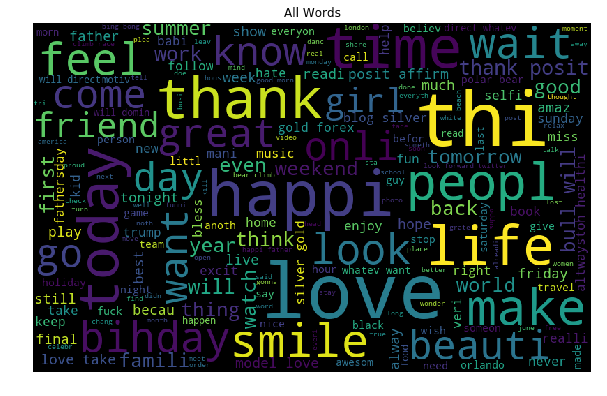

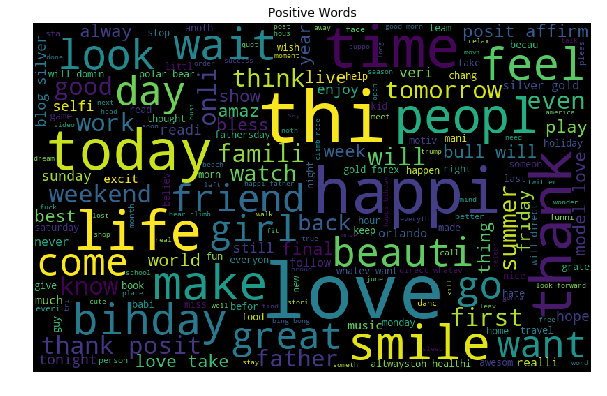

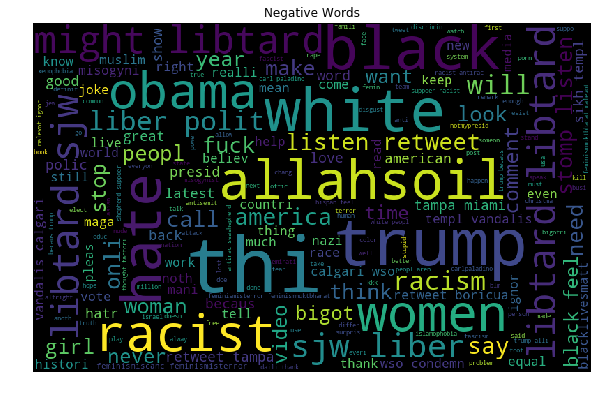

In [89]:
#Plot All word Wordcloud
def plot_wordcloud(words,title):
    wordcloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(words)
    plt.figure(figsize=(10,7))
    plt.axis('off')
    plt.title(title)
    plt.imshow(wordcloud)

plot_wordcloud(all_words,'All Words')
plot_wordcloud(pos_words,'Positive Words')
plot_wordcloud(neg_words,'Negative Words')




## Exploring Hashtags ##
Next I plot the frequency distrbution for top 10 positive and negative hashtags. This is just for exploration purposes, makes no difference on modelling. We can also train a different model for hashtags and use it along with a model for tweets as hashtags do provide additional insight for sentiment of the tweet, but I have not done that in this code

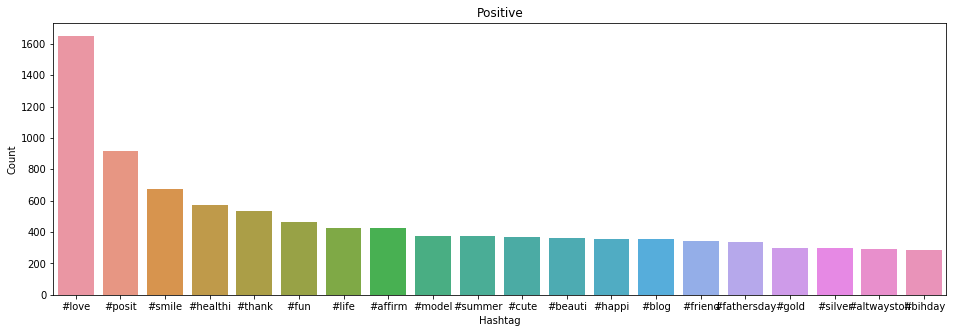

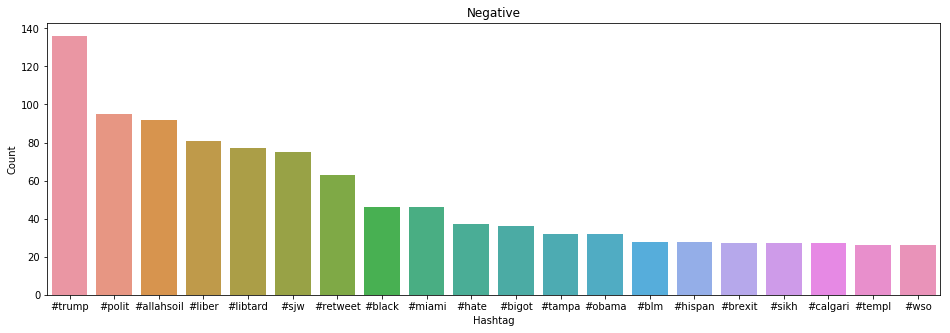

In [90]:
##Get hashtags from strings
def hashtags(input_text):
    ht = re.findall(r'#\w+',input_text)
    return ht

HT_regular = hashtags(pos_words)
HT_negative = hashtags(neg_words)

def plot_freq_dist(listofwords,title):
    ##plot freuqency distribution
    a = nltk.FreqDist(listofwords)
    d = pd.DataFrame({
        'Hashtag':list(a.keys()),
        'Count':list(a.values())
    })
    d=d.nlargest(20,'Count')
    plt.figure(figsize=(16,5))
    ax = sns.barplot(data=d,x='Hashtag',y='Count')
    ax.set(ylabel='Count',title=title)
    plt.show()

plot_freq_dist(HT_regular,'Positive')
plot_freq_dist(HT_negative,'Negative')


## Processing the inputs ##
Now that we have preprocessed tweets, there are multiple options available to model that. In the code below, I explore the following options : 
<ul>
    <li> <strong>Bag of words</strong> : Here each tweet is considered as unordered collection of words. From the complete corpus, we get a vocabulary, the narrange the vocabulary in some order. Each tweet can be represented as a vector of count of words in the tweet </li>
    <li> <strong> TF IDF </strong> : This is same as Bag of words except we divide word frequencies by the total number of times the word has appeard in the corpus, also called <em> doc frequency </em>. </li>
    <li> <strong> One hot encoding </strong> </li>
    <li> <strong> Word2Vec </strong> :  The word2vec algorithm uses a neural network model to learn word associations from a large corpus of text. Once trained, such a model can detect synonymous words or suggest additional words for a partial sentence. We'll be using Skipgram mode of word 2 vec</li>
    <li> <strong> Doc2Vec </strong> : This is same as word2vec but instead of creating vectors for individual words, this version creates vectors for model.  </li>
        

In [92]:
# Bag of words, TF IDF , Word2Vec embeddings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer 
import gensim

bow_Vectorizer = CountVectorizer(max_df=0.9,min_df=2,max_features=1000,stop_words='english')
bow = bow_Vectorizer.fit_transform(combined.tweet)

tfidf_Vectorizer = TfidfVectorizer(max_df=0.9,min_df=2,max_features=1000,stop_words='english')
tfidf = tfidf_Vectorizer.fit_transform(combined.tweet)


In [93]:
tokenized_tweets = combined.tweet.apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(
    tokenized_tweets, 
    size = 200, #Dimension of output vector
    window = 5, #Context Window size
    min_count = 2,
    sg = 1 , #skipgram model
    negative = 10,
    workers = 4, #no. of cores
    seed = 34
)

model_w2v.train(tokenized_tweets,total_examples = len(combined.tweet),epochs=10)



(3263158, 3787130)

Next I check if the w2v model is performing as expected by using <em>most_similar </em> method

In [115]:
print('Most similar words compared to {}: \n\n{} '.format('trump',model_w2v.most_similar('trump')))

print('\nMost similar words compared to {}: \n\n{} '.format('drink',model_w2v.most_similar('drink')))

Most similar words compared to trump: 

[('hillari', 0.6611512899398804), ('nomine', 0.626013994216919), ('unstabl', 0.6258085370063782), ('berni', 0.6219433546066284), ('putin', 0.6126148700714111), ('unfavor', 0.6071757674217224), ('commi', 0.6046433448791504), ('presumpt', 0.6036618947982788), ('fraud', 0.6027207970619202), ('presidenti', 0.601915717124939)] 

Most similar words compared to drink: 

[('prawn', 0.6638484001159668), ('grang', 0.6622024774551392), ('#aplk', 0.6483880877494812), ('blanket', 0.6337280869483948), ('equi', 0.6294082403182983), ('cone', 0.6257799863815308), ('#jagerbomb', 0.618942379951477), ('roast', 0.6185774803161621), ('pool', 0.6180219650268555), ('#english', 0.6171408891677856)] 


In [116]:
# Take average of vectors in a word
def create_word2vec_arrays(tokens,size):
    vec = np.zeros(size).reshape(1,size)
    count = 0
    for word in tokens:
        count+=1
        try:
            vec += model_w2v[word].reshape(1,size)
        except:
            KeyError
    if count !=0:
        vec /= count
    return vec

wordvec_array = np.zeros((combined.shape[0],200))
for i, tweet in enumerate(tokenized_tweets):
    wordvec_array[i] = create_word2vec_arrays(tweet,200)

wordvec_df = pd.DataFrame(wordvec_array)
    

In [95]:
from tqdm import tqdm
tqdm.pandas(desc='progress-bar')
from gensim.models.doc2vec import TaggedDocument
def add_label(tweet):
    index = range(len(tweet))
    output = []
    for i,s in zip(index,tweet):
        output.append(TaggedDocument(s,['tweet'+str(i)]))
    return output

In [96]:
labeled_tweets = add_label(tokenized_tweets)

model_d2v = gensim.models.Doc2Vec(dm=1,
                                 dm_mean = 1, #use mean of words
                                 vector_size = 200,
                                 window= 5,
                                 negative = 7,
                                 min_count=5,
                                 workers =4,
                                 alpha=0.1,
                                 seed=23 
                                 )
model_d2v.build_vocab(labeled_tweets)
model_d2v.train(labeled_tweets,total_examples=len(labeled_tweets),epochs=15)

In [97]:
docvec_arrays = np.zeros((len(labeled_tweets),200))
for i in range(len(combined.tweet)):
    docvec_arrays[i,:] = model_d2v.docvecs[i].reshape(1,200)
docvec_df = pd.DataFrame(docvec_arrays)

In [98]:
wordvec_df[:1]

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,-0.067122,-0.090915,-0.256151,-0.307113,0.030464,0.057377,-0.348349,-0.21794,-0.096539,0.153127,...,0.120052,-0.188284,-0.109938,-0.012654,-0.003804,0.170905,-0.126289,-0.309488,-0.049624,0.021393


In [24]:
#Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


#Split combined into train test
train_bow = bow[:train.shape[0],:]
test_bow = bow[train.shape[0]:,:]

train_tfidf = tfidf[:train.shape[0],:]
test_tfidf = tfidf[train.shape[0]:,:]

train_w2v = wordvec_df[:train.shape[0]]
test_w2v = wordvec_df[train.shape[0]:]

train_d2v = docvec_df[:train.shape[0]]
test_d2v = docvec_df[train.shape[0]:]

#Try Logistic regression
#Bag of words features
def fit_lreg(features,labels,threshold=0.3):
    lreg = LogisticRegression()
    xtrain, xvalid, ytrain, yvalid = train_test_split(features,labels,random_state=42,test_size=0.3)
    lreg.fit(xtrain,ytrain)
    prediction = lreg.predict_proba(xvalid)
    prediction = prediction[:,1]>=threshold
    prediction = prediction.astype(np.int)
    return f1_score(yvalid,prediction)

threshold = 0.3
f1=[]
f1.append(fit_lreg(train_bow,train['label'],threshold))
f1.append(fit_lreg(train_tfidf,train['label'],threshold))
f1.append(fit_lreg(train_w2v, train['label'],threshold))
f1.append(fit_lreg(train_d2v, train['label'],threshold))
scores = {'Algo':'LR', 'BoW':f1[0], 'TFIDF':f1[1],'Word2Vec':f1[2],f1[3]='Doc2Vec'}
print('Scores:\n Bag of words : {}\n TFIDF : {}\n Word2Vec : {}\n Doc2vec : {}'.format(f1[0],f1[1],f1[2],f1[3]))

C:\Users\pnkjp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\pnkjp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Scores:
 Bag of words : 0.5492142266335814
 TFIDF : 0.5588752196836555
 Word2Vec : 0.619047619047619
 Doc2vec : 0.37768240343347637


In [35]:
#Try SVM
from sklearn import svm
def fit_svm(features,labels,threshold=0.3):
    xtrain, xvalid, ytrain, yvalid = train_test_split(features,labels,random_state=42,test_size=0.3)
    svc = svm.SVC(kernel='linear',C=1,probability=True).fit(xtrain,ytrain)
    prediction = svc.predict_proba(xvalid)
    prediction = prediction[:,1]>=threshold
    prediction = prediction.astype(np.int)
    return f1_score(yvalid,prediction)

f1_svm=[]
f1_svm.append(fit_svm(train_bow,train['label'],threshold))
f1_svm.append(fit_svm(train_tfidf,train['label'],threshold))
f1_svm.append(fit_svm(train_w2v, train['label'],threshold))
f1_svm.append(fit_svm(train_d2v, train['label'],threshold))

print('Scores:\n Bag of words : {}\n TFIDF : {}\n Word2Vec : {}\n Doc2vec : {}'.format(f1_svm[0],f1_svm[1],f1_svm[2],f1_svm[3]))

Scores:
 Bag of words : 0.520220588235294
 TFIDF : 0.5216606498194946
 Word2Vec : 0.6131045241809672
 Doc2vec : 0.21788990825688073


In [44]:
#Try RandomForest
from sklearn.ensemble import RandomForestClassifier
def fit_rf(features,labels):
    xtrain, xvalid, ytrain, yvalid = train_test_split(features,labels,random_state=42,test_size=0.3)
    rf = RandomForestClassifier(n_estimators=400,random_state=42).fit(xtrain,ytrain)
    prediction = rf.predict(xvalid)
    return f1_score(yvalid,prediction)

f1_rf=[]
f1_rf.append(fit_rf(train_bow,train['label']))
f1_rf.append(fit_rf(train_tfidf,train['label']))
f1_rf.append(fit_rf(train_w2v,train['label']))
f1_rf.append(fit_rf(train_d2v,train['label']))

print('Scores:\n Bag of words : {}\n TFIDF : {}\n Word2Vec : {}\n Doc2vec : {}'.format(f1_rf[0],f1_rf[1],f1_rf[2],f1_rf[3]))

Scores:
 Bag of words : 0.5523210070810386
 TFIDF : 0.5598526703499079
 Word2Vec : 0.5377456049638055
 Doc2vec : 0.06770098730606489


In [47]:
scores

{'Algo': 'LR',
 'BoW': 0.5523210070810386,
 'TFIDF': 0.5598526703499079,
 'Word2Vec': 0.5377456049638055,
 'Doc2Vec': 0.06770098730606489}

In [65]:
#Try XGBoost
from xgboost import XGBClassifier
def fit_xgb(features, labels,threshold = 0.3):
    xtrain,xvalid,ytrain,yvalid = train_test_split(features,labels,random_state=42,test_size=0.3)
    xgb_model = XGBClassifier(max_depth = 6, n_estimators=1000).fit(xtrain,ytrain)
    predictions = xgb_model.predict_proba(xvalid)
    predictions = predictions[:,1]>=threshold
    predictions = predictions.astype(np.int)
    return f1_score(yvalid,predictions)

f1_xgb=[]
f1_xgb.append(fit_xgb(train_bow,train['label']))
f1_xgb.append(fit_xgb(train_tfidf,train['label']))
f1_xgb.append(fit_xgb(train_w2v,train['label']))
f1_xgb.append(fit_xgb(train_d2v,train['label']))
print('Scores:\n Bag of words : {}\n TFIDF : {}\n Word2Vec : {}\n Doc2vec : {}'.format(f1_xgb[0],f1_xgb[1],f1_xgb[2],f1_xgb[3]))    

C:\Users\pnkjp\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pnkjp\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:20:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pnkjp\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:21:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\pnkjp\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:27:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Scores:
 Bag of words : 0.5689519306540584
 TFIDF : 0.5548489666136724
 Word2Vec : 0.6795626576955425
 Doc2vec : 0.43092783505154647


In [85]:
#Wrod2vec and XGB combo worked best, try hyperparameter tuning
import xgboost as xgb
xtrain,xvalid,ytrain,yvalid = train_test_split(train_w2v,train['label'],random_state=42,test_size=0.3)
   
dtrain = xgb.DMatrix(xtrain,ytrain)
dvalid = xgb.DMatrix(xvalid,yvalid)
dtest = xgb.DMatrix(test_w2v)

params = {
    'objective':'binary:logistic',
    'max_depth': 6,
    'min_child_weight':1,
    'eta':0.3,
    'subsample': 1,
    'colsample_bytree':1
}

def custom_eval(preds,dtrain):
    labels = dtrain.get_label().astype(np.int)
    preds = (preds>=0.3).astype(np.int)
    return [('f1_score',f1_score(labels,preds))]

In [91]:
import warnings
warnings.filterwarnings('ignore',category = DeprecationWarning)
gridsearch_params = [
    (max_depth,min_child_weight)
    for max_depth in range(6,10)
    for min_child_weight in range(5,8)
]
max_f1 = 0
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print('CV with max depth = {}, min_child_weight = {}'.format(max_depth,min_child_weight))
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    cv_results = xgb.cv(params,dtrain,feval = custom_eval,num_boost_round=200,maximize=True,seed=42,nfold=5,early_stopping_rounds=10)
    mean_f1 = cv_results['test-f1_score-mean'].max()
    boost_rounds = cv_results['test-f1_score-mean'].argmax()
    print('\tF1 score {} for {} rounds'.format(mean_f1,boost_rounds))
    if mean_f1>max_f1:
        max_f1 = mean_f1
        best_params = [max_depth,min_child_weight]
    
print("Best Params: {}, {}, F1 Score = {}".format(best_params[0],best_params[1],max_f1))    

CV with max depth = 6, min_child_weight = 5
[12:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:06:27] WARNING: C:/Use

CV with max depth = 9, min_child_weight = 6
[12:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:39:16] WARNING: C:/Use